# Modell der hämodynamischen Antwort

### module importieren

In [42]:
import numpy as np
from nilearn import image, input_data, plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats
from nistats import hemodynamic_models

sns.set_context('poster')

### Dateiname des funktionellen Bildes

In [2]:
epi_file = '../data/sub-01_task-imagery_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'

In [3]:
epi_file

'../data/sub-01_task-imagery_run-02_bold_space-MNI152NLin2009cAsym_preproc.nii.gz'

### Daten aus Seed extrahieren

Koordinaten der interessierenden Region

In [4]:
my_seeds = [ (0,-50,30) ]

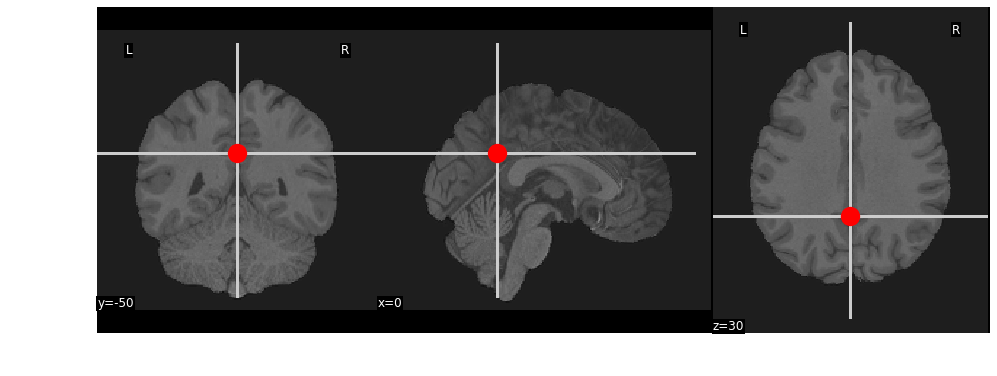

In [43]:
fig,ax = plt.subplots(1,1,figsize=(16,6))
display = plotting.plot_anat('../data/sub-01_T1w_space-MNI152NLin2009cAsym_preproc.nii.gz',
                             cut_coords=my_seeds[-1],
                             axes=ax)
display.add_markers(my_seeds,marker_size=300)
plt.show()

Extraktion der Daten aus der Region

In [6]:
my_standard = True
my_detrend = True
my_smoo = 8

In [7]:
seed_masker = input_data.NiftiSpheresMasker(seeds=my_seeds,
                                            radius=5,
                                            standardize=my_standard,
                                            detrend=my_detrend,
                                            smoothing_fwhm=my_smoo).fit()

In [ ]:
seed_data = seed_masker.transform(epi_file)

seed_df = pd.DataFrame(seed_data)
seed_df.columns = ['signal']

In [9]:
seed_df.tail()

,signal
198,3.030387
199,1.135545
200,2.084397
201,0.347538
202,-0.757389


Check: wenn das Detrending funktioniert hat, dann muss der Signalverlauf über alle Volumen hinweg flach sein

In [10]:
linreg_results = stats.linregress(seed_df.index,seed_df['signal'])

In [11]:
print('Schnittpunkt der y-Achse=%.5f\nSteigung der Geraden=%.5f'%(linreg_results.intercept, linreg_results.slope))

Schnittpunkt der y-Achse=0.00000
Steigung der Geraden=0.00000


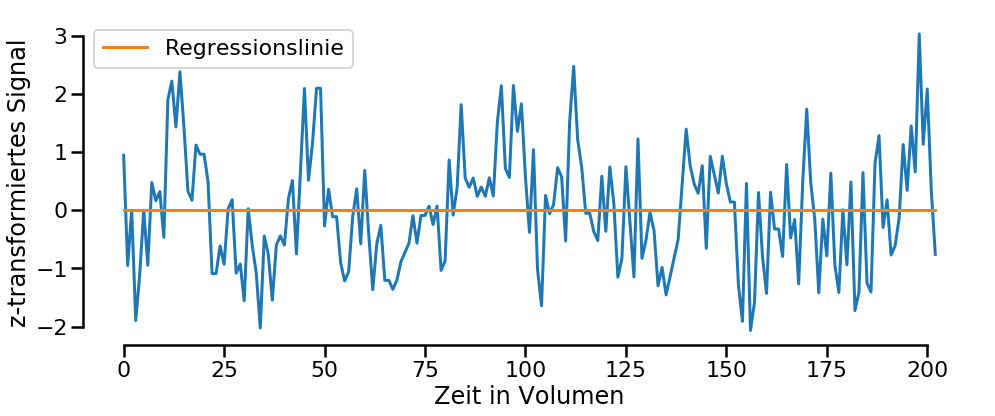

In [12]:
plt.figure(figsize=(16,6))

# die Daten der Seed-Region
plt.plot(seed_df)

# die Ergebnisse der linearen Regression
plt.plot([linreg_results.intercept+linreg_results.slope*x for x in seed_df.index],
         label='Regressionslinie')

plt.ylabel('z-transformiertes Signal')
plt.xlabel('Zeit in Volumen')
plt.legend()
sns.despine(trim=True)
plt.show()

### Studiendesign laden

In [13]:
design_df = pd.read_csv('../data/sub-01_task-imagery_run-02_events.tsv',sep='\t',index_col=[2,4])
design_df = design_df.sort_index()
design_df

onset  duration trial_subdomain
trial_domain trial_content                                      
EMOTION      Berg                  450        30         Positiv
             See                   240        30         Positiv
             Strand                360        30         Negativ
             Waldbrand              90        30         Negativ
GESICHTER    Kommilitonen           30        30         Bekannt
             Schulfreunde          330        30         Bekannt
             Serienschauspieler    150        30        Beruehmt
             Sportler              510        30        Beruehmt
MOTORIK      Ballwerfen            390        30          Haende
             Boxen                   0        30          Haende
             Hochseil              210        30          Fuesse
             Trampolin             540        30          Fuesse
RUHE         Ruhe                  120        30            Ruhe
             Ruhe                  270        30            Ruhe
             Ruhe                  420        30            Ruhe
             Ruhe                  570        30            Ruhe
SPRACHE      Lebensmittel           60        30        Sprechen
             Staedte               480        30       Schreiben
             Tiere                 180        30       Schreiben
             Vornamen              300        30        Sprechen

## Modell der hämodynamischen Antwort

In [14]:
my_tr = 3.0
my_onset = 0.0
my_length = 32.0

In [ ]:
hrf_model = hemodynamic_models.spm_hrf(tr=my_tr,
                                   oversampling=my_tr,
                                   time_length=my_length+my_onset,
                                   onset=my_onset)

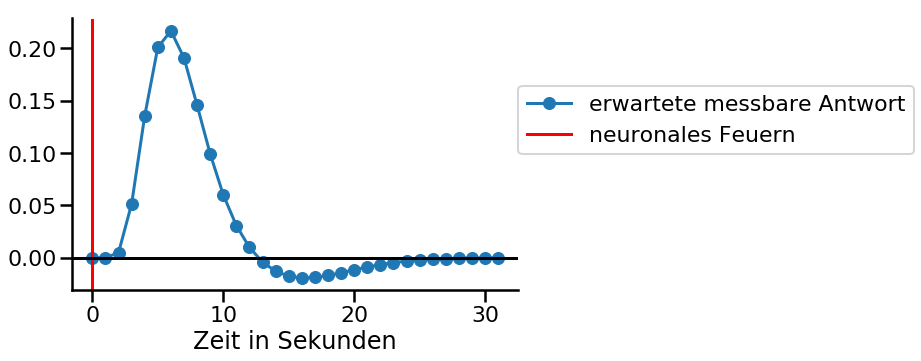

In [16]:
plt.figure(figsize=(8,5))
plt.plot(hrf_model,'-o',label='erwartete messbare Antwort')
plt.axvline(my_onset,color='r',label='neuronales Feuern')
plt.axhline(0,color='k')
sns.despine()
plt.legend(loc=(1,0.5))
plt.xlabel('Zeit in Sekunden')
plt.show()

### Interaktives Verschieben der HRF

In [17]:
from ipywidgets import interact

In [18]:
def f(my_onset):
    hrf_model = hemodynamic_models.spm_hrf(tr=my_tr,
                                       oversampling=my_tr,
                                       time_length=my_length+my_onset,
                                       onset=my_onset)
    plt.figure(figsize=(8,5))
    plt.plot(hrf_model,'-o',label='erwartete messbare Antwort')
    plt.axvline(my_onset,color='r',label='neuronales Feuern')
    plt.axhline(0,color='k')
    sns.despine()
    plt.legend(loc=(1,0.5))
    plt.xlabel('Zeit in Sekunden')
    plt.show()

In [19]:
interact(f,my_onset=(0.0,30.0));

interactive(children=(FloatSlider(value=15.0, description='my_onset', max=30.0), Output()), _dom_classes=('wid…

### Hypothetisches Design

Eine Minute passiert nichts:

In [20]:
beispiel_design = np.zeros(60)
beispiel_design

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

Ein Event bei Sekunde 30 hinzufügen

In [21]:
beispiel_design[30] = 1.0

In [22]:
beispiel_design

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

Liste mit Events:

In [23]:
event_onsets = np.where(beispiel_design==1)[-1]
event_onsets

array([30])

### Abbildung mit Events und erwarteter Aktivierung

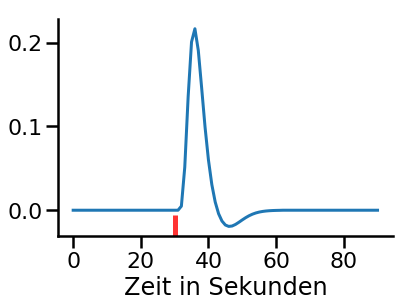

In [24]:
plt.plot(np.convolve(beispiel_design,hrf_model))
sns.rugplot(event_onsets,color='r',height=0.1,linewidth=5,alpha=0.8)
plt.xlabel('Zeit in Sekunden')
sns.despine()
plt.show()

### Noch mehr Events hinzufügen

In [25]:
beispiel_design[3] = 1.0
beispiel_design[33] = 1.0
beispiel_design[34] = 1.0
beispiel_design[45] = 1.0

In [26]:
event_onsets = np.where(beispiel_design==1)[-1]
event_onsets

array([ 3, 30, 33, 34, 45])

### Abbildung die zeigt was passiert, wenn sich HRFs überlappen

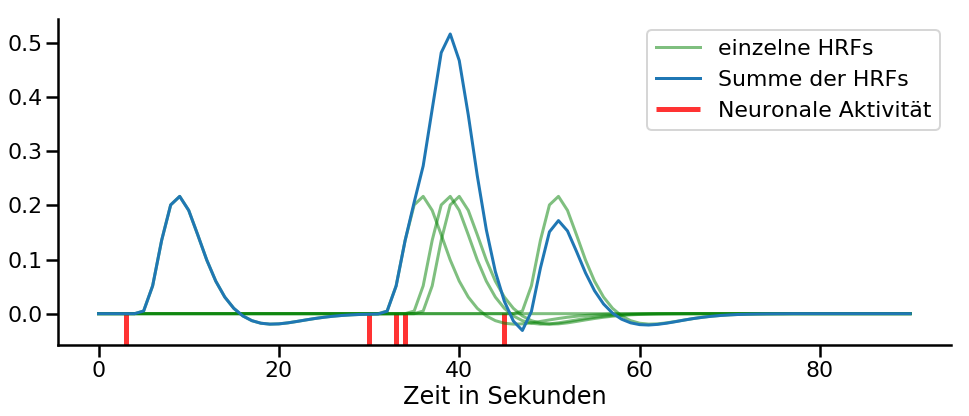

In [27]:
plt.figure(figsize=(16,6))
for event in event_onsets:
    single_hrf = np.zeros(60)
    single_hrf[event] = 1.0
    plt.plot(np.convolve(single_hrf,hrf_model),color='g',alpha=0.5)
plt.plot([],color='g',alpha=0.5,label='einzelne HRFs')
plt.plot(np.convolve(beispiel_design,hrf_model),label='Summe der HRFs')
sns.rugplot(event_onsets,color='r',height=0.1,linewidth=5,alpha=0.8,label='Neuronale Aktivität')
plt.legend(loc='best')
plt.xlabel('Zeit in Sekunden')
sns.despine()
plt.show()

### Design der Studie modellieren

Anzahl der Volumen in der Zeitserie

In [28]:
number_of_volumes = image.load_img(epi_file).shape[-1]
number_of_volumes

203

Zeit in Sekunden = Anzahl Volumen x TR

In [29]:
beispiel_design = np.zeros(int(number_of_volumes*my_tr))
beispiel_design.shape[-1]

609

Onsets und Duration der Ruhebedingung

In [30]:
ruhe_onsets = design_df.loc['RUHE',['onset','duration']]
ruhe_onsets

,onset,duration
trial_content,,
Ruhe,120,30
Ruhe,270,30
Ruhe,420,30
Ruhe,570,30


Alle Onsets einer Bedingung

In [31]:
def make_onsets(df,number_of_volumes=number_of_volumes,my_tr=my_tr):
    design = np.zeros(int(number_of_volumes*my_tr))
    # für jede Zeile in der Tabelle
    for start in range(df.shape[0]):
        # Inhalte der Zeile
        block = df.iloc[start]
        # Onsets und Durations extrahieren
        block_onset = block['onset']
        block_duration = block['duration']
        # Ab Onset so viele 1en einfügen wie der Block lang ist
        for event in range(block_duration):
            design[block_onset+event] = 1.
    return design

In [32]:
beispiel_design = make_onsets(ruhe_onsets)

In [33]:
beispiel_design

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0.

Original An/Aus Design (Boxcar) oder mit HRF verbunden

In [34]:
boxcar_design_in_tr = beispiel_design[::int(my_tr)]
boxcar_design_in_tr

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0.])

In [35]:
hrf_design_in_tr = np.convolve(beispiel_design,hrf_model)[::int(my_tr)]

### Abbildung mit Daten und Modellen

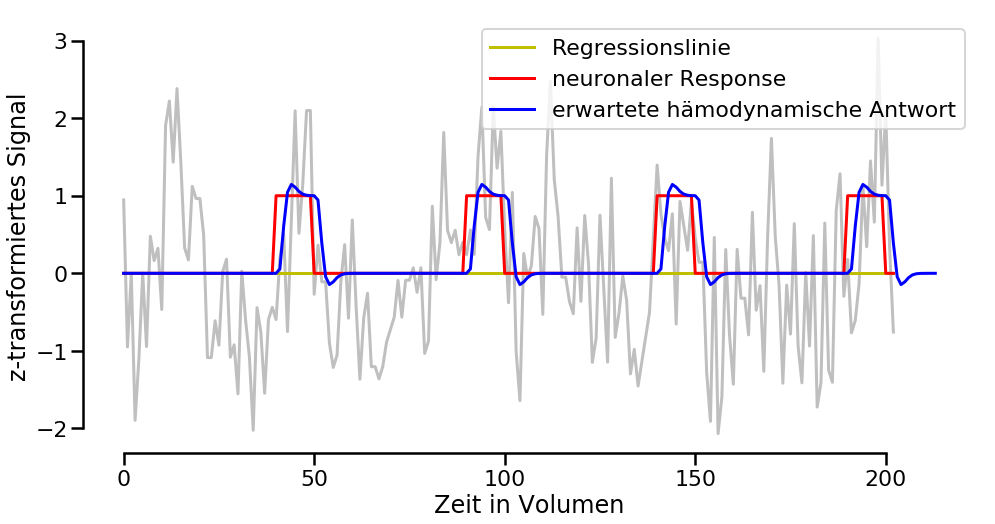

In [36]:
plt.figure(figsize=(16,8))

# die Daten der Seed-Region
plt.plot(seed_df,color='grey',alpha=0.5)
# die Ergebnisse der linearen Regression
plt.plot([linreg_results.intercept+linreg_results.slope*x for x in seed_df.index],
         label='Regressionslinie',color='y')

# ein-aus-Design
plt.plot(boxcar_design_in_tr,color='r',label='neuronaler Response')
# HRF-Design
plt.plot(hrf_design_in_tr,'b',label='erwartete hämodynamische Antwort')

plt.legend(loc='best')

plt.ylabel('z-transformiertes Signal')
plt.xlabel('Zeit in Volumen')
sns.despine(trim=True)
plt.show()

### Korrelation Daten mit Design

In [37]:
seed_df.corrwith(pd.Series(boxcar_design_in_tr))

signal    0.389957
dtype: float64

In [38]:
seed_df.corrwith(pd.Series(hrf_design_in_tr))

signal    0.428732
dtype: float64

### Korrelation mit anderen Bedingungen

In [39]:
beispiel_design = make_onsets(design_df.loc['MOTORIK',['onset','duration']])
boxcar_design_in_tr = beispiel_design[::int(my_tr)]
hrf_design_in_tr = np.convolve(beispiel_design,hrf_model)[::int(my_tr)]

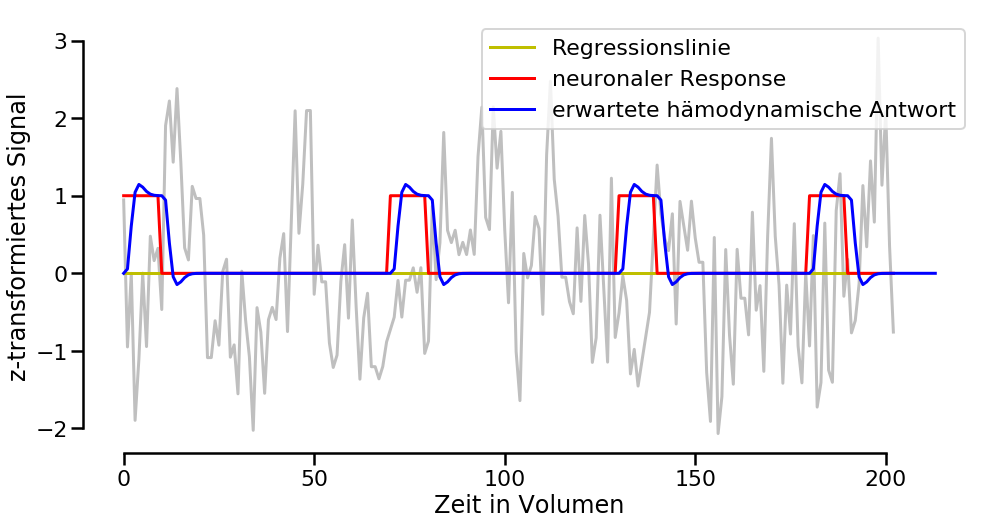

In [40]:
plt.figure(figsize=(16,8))

# die Daten der Seed-Region
plt.plot(seed_df,color='grey',alpha=0.5)
# die Ergebnisse der linearen Regression
plt.plot([linreg_results.intercept+linreg_results.slope*x for x in seed_df.index],
         label='Regressionslinie',color='y')

# ein-aus-Design
plt.plot(boxcar_design_in_tr,color='r',label='neuronaler Response')
# HRF-Design
plt.plot(hrf_design_in_tr,'b',label='erwartete hämodynamische Antwort')

plt.legend(loc='best')

plt.ylabel('z-transformiertes Signal')
plt.xlabel('Zeit in Volumen')
sns.despine(trim=True)
plt.show()